<class 'numpy.ndarray'>
(10000, 8)
[ 1.26000000e+02  6.16877091e-02 -7.73996295e-01 -7.02134033e-01
  4.82019478e-01  5.94862720e-01  7.20000000e+01  7.80000000e+01]
                  0             1             2             3             4  \
count  10000.000000  10000.000000  10000.000000  10000.000000  10000.000000   
mean     173.537100     -0.019274     -0.055412     -0.020011     -0.011571   
std       60.260391      0.996798      0.936588      0.964146      1.002931   
min        0.000000     -1.103657     -1.129803     -1.047126     -1.145616   
25%      129.000000     -0.590254     -0.716672     -0.713789     -0.582796   
50%      177.000000     -0.321731     -0.312765     -0.291873     -0.341801   
75%      220.000000      0.196213      0.338229      0.379464      0.184171   
max      286.000000     23.984711     12.604339      7.820110     14.910312   

                  5             6             7  
count  10000.000000  10000.000000  10000.000000  
mean       0.006253   

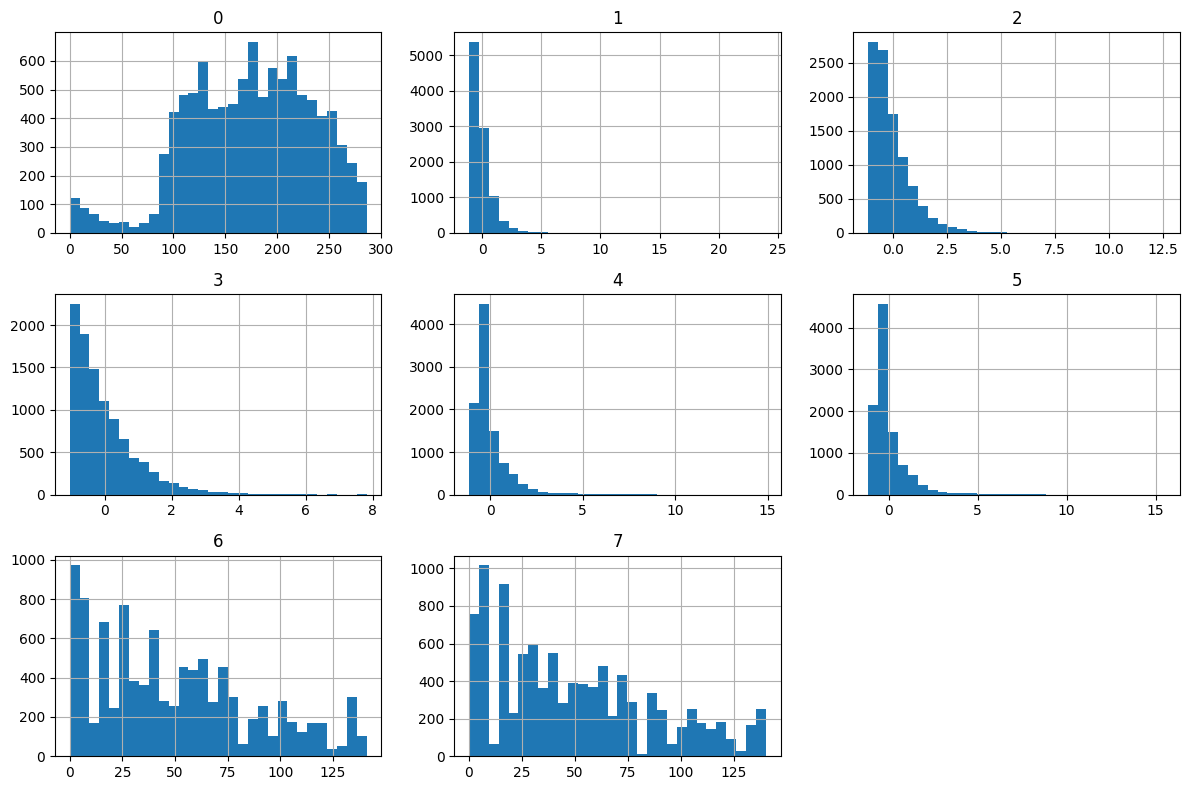

In [ ]:
# inspect the original head file

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Load the .npy file
heads = np.load('heads.npy', allow_pickle=True)

# Inspect the content
print(type(heads))
print(heads.shape)
print(heads[3])  # example: print the first element

# If each head is a vector (list/array of numbers)
df = pd.DataFrame(heads)

# Basic statistics
print(df.describe())

# Optional: visualize distributions


df.hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()

# 0, 6, 7 are categorical values

-[x] Normalize coordinates using provided lon/lat mean and std. \
-[x] convert the distance into meters

In [1]:
# import data
import pandas as pd
from ast import literal_eval
from tqdm import tqdm

tqdm.pandas()
df = pd.read_csv("dataset\porto.csv")


# convert the POLYLINE from str to list
import multiprocessing as mp
from ast import literal_eval

with mp.Pool(processes=mp.cpu_count()) as pool:
    results = list(tqdm(
        pool.imap(literal_eval, df['POLYLINE']),
        total=len(df),
        desc="Parsing POLYLINE"
    ))
    

Parsing POLYLINE: 100%|██████████| 1710670/1710670 [03:33<00:00, 7999.01it/s]


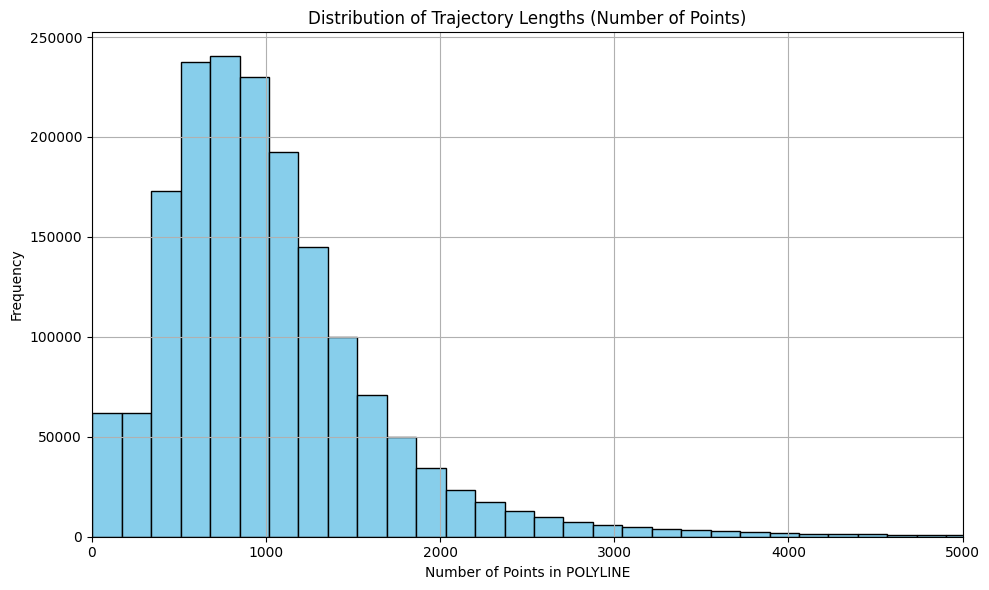

In [11]:
# plot distribution of trajectory length, do not execute!
import matplotlib.pyplot as plt

# Compute lengths
lengths = df['POLYLINE'].apply(len)

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=500, color='skyblue', edgecolor='black')
plt.title("Distribution of Trajectory Lengths (Number of Points)")
plt.xlabel("Number of Points in POLYLINE")
plt.ylabel("Frequency")
plt.xlim(0, 5000)
plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
# drop the data less than threshold
df_pp = pd.DataFrame({'POLYLINE': results, 'TIMESTAMP': df['TIMESTAMP']})

# drop length of POLYLINE < 100
len_before = len(df_pp)

# df_pp.drop(df[df['POLYLINE'].apply(len) < 2].index, inplace=True)
df_pp.drop(df_pp[df_pp['POLYLINE'].apply(len) < 80].index, inplace=True)

len_after  = len(df_pp)

print(f"there are {len_before - len_after} instances has the number of locations points less than 50")
print(f"there are {len(df_pp)} trajectories left.")

there are 1526924 instances has the number of locations points less than 50
there are 183746 trajectories left.


In [3]:
# free memory
del df
del results

In [4]:
# trim all trajectories out of administrative range
import osmnx as ox

# Get Porto bounding box
porto = ox.geocode_to_gdf("Porto, Portugal")
bounds = porto.total_bounds  # [minx, miny, maxx, maxy] in EPSG:4326
bbox = (bounds[0], bounds[1], bounds[2], bounds[3])  # (min_lon, min_lat, max_lon, max_lat)


# download the administrative range from openstreetmap
import numpy as np
import pandas as pd
from tqdm import tqdm

def filter_polylines_in_bbox(df, bbox, keep_ratio=0.5):
    """
    Drops polylines that lie mostly outside the bounding box.

    Parameters:
        df (pd.DataFrame): DataFrame with a 'POLYLINE' column (list of [lon, lat])
        bbox (tuple): Bounding box in (min_lon, min_lat, max_lon, max_lat)
        keep_ratio (float): Minimum fraction of points that must lie inside the bbox to keep a trajectory

    Returns:
        pd.DataFrame: Filtered DataFrame
    """
    min_lon, min_lat, max_lon, max_lat = bbox
    kept_rows = []

    for i, poly in tqdm(enumerate(df['POLYLINE']), total=len(df), desc="Filtering POLYLINE"):
        if not poly or len(poly) == 0:
            continue  # skip empty

        poly_np = np.array(poly)  # shape: (n_points, 2)
        lon_in = (poly_np[:, 0] >= min_lon) & (poly_np[:, 0] <= max_lon)
        lat_in = (poly_np[:, 1] >= min_lat) & (poly_np[:, 1] <= max_lat)
        inside = lon_in & lat_in

        inside_ratio = inside.sum() / len(poly_np)

        if inside_ratio >= keep_ratio:
            kept_rows.append(i)

    return df.iloc[kept_rows].reset_index(drop=True)

# trim it

df_pp = filter_polylines_in_bbox(df_pp, bbox, keep_ratio=1)

print(f"there are {len(df_pp)} trajectories left")

Filtering POLYLINE: 100%|██████████| 183746/183746 [00:04<00:00, 45166.91it/s]


there are 90649 trajectories left


Processing trajectories...


Converting polylines to LineStrings: 100%|██████████| 90649/90649 [00:02<00:00, 31429.90it/s]


Plotting map...


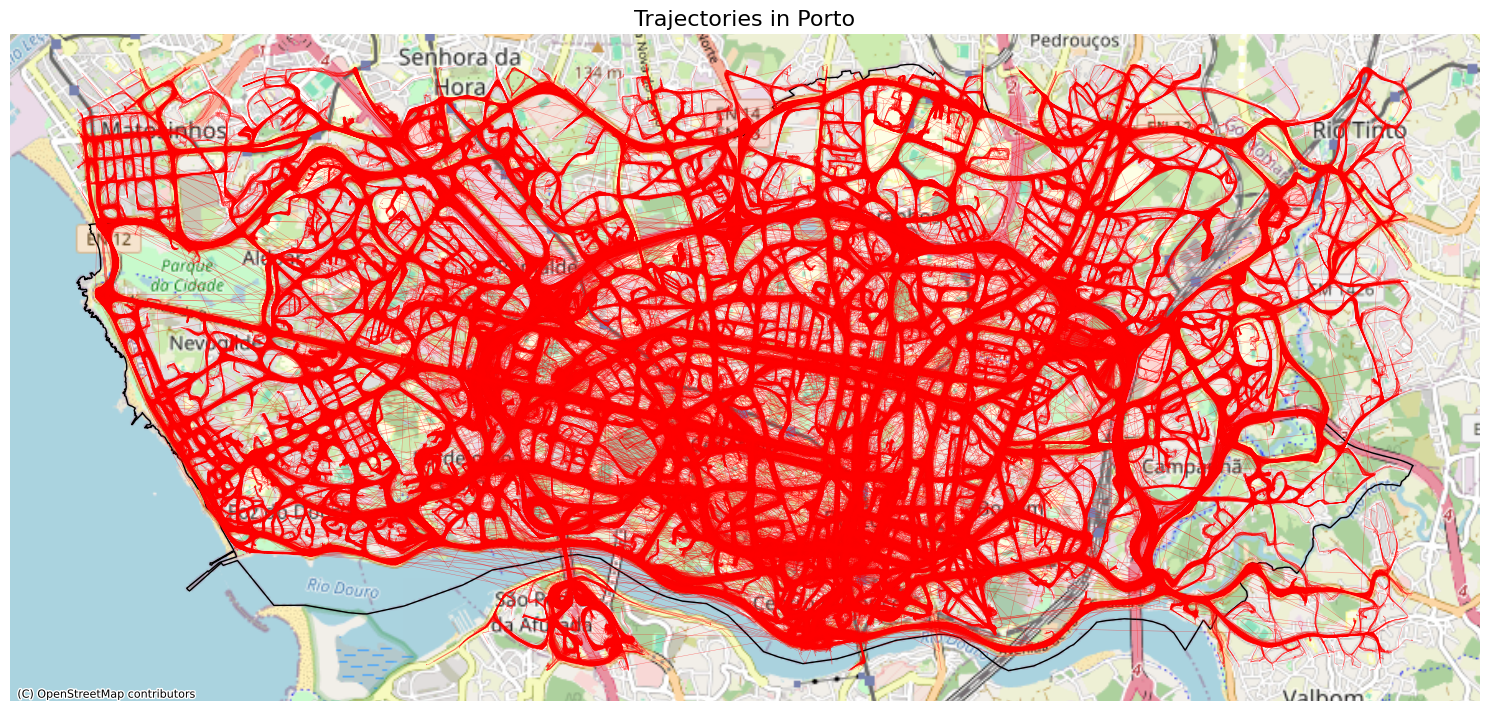

Converting POLYLINE to LineStrings: 100%|██████████| 90649/90649 [00:02<00:00, 31123.07it/s]


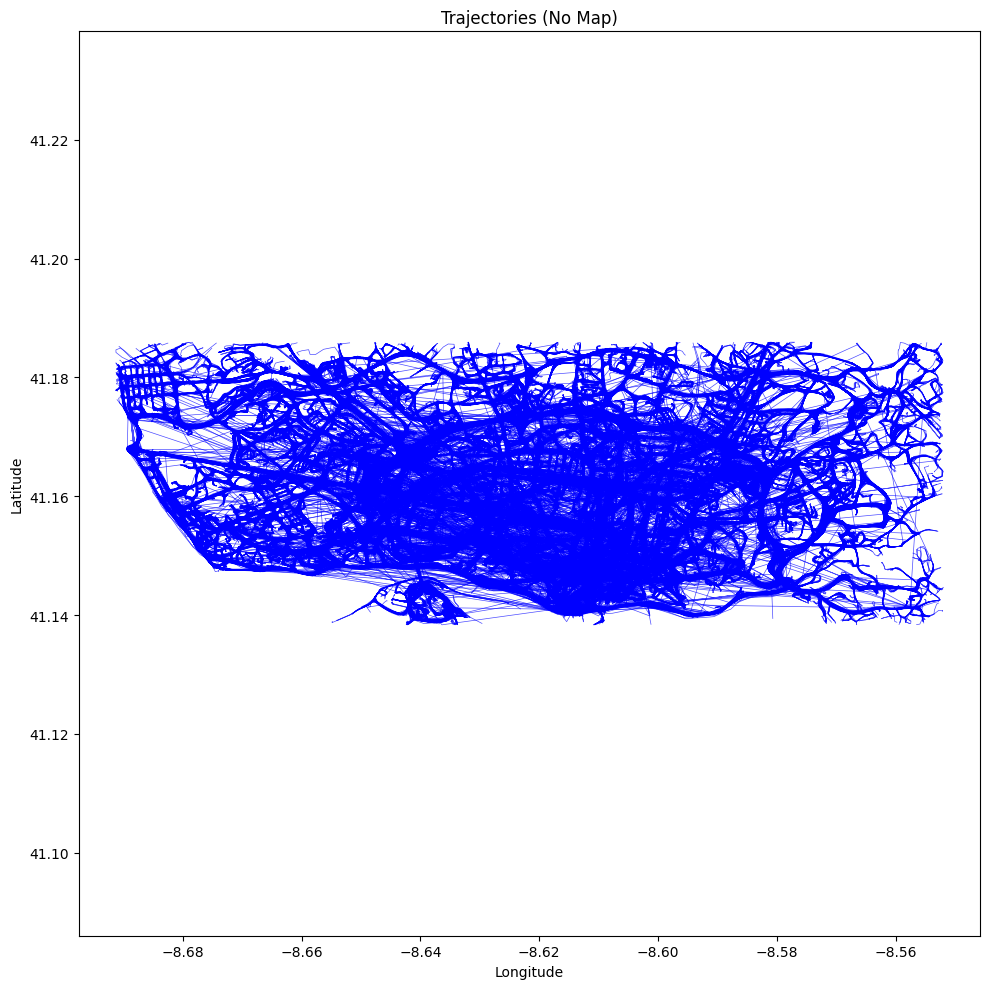

In [4]:
# plot trajectory, do not execute!

import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as cx
from tqdm import tqdm
from shapely.geometry import LineString

def plot_trajectories_on_porto_map(df):
    """
    Plot all POLYLINE trajectories in a DataFrame onto the map of Porto.

    Parameters:
        df (pd.DataFrame): DataFrame with a 'POLYLINE' column (list of [lon, lat] points).
    """
    print("Downloading Porto boundary...")
    porto = ox.geocode_to_gdf("Porto, Portugal").to_crs(epsg=3857)
    bounds = porto.total_bounds  # (minx, miny, maxx, maxy)

    print("Processing trajectories...")
    line_geoms = []
    for poly in tqdm(df['POLYLINE'], desc="Converting polylines to LineStrings"):
        if (isinstance(poly, list) and len(poly) > 1) or (isinstance(poly, np.ndarray) and len(poly) > 1):
            try:
                line = LineString(poly)
                line_geoms.append(line)
            except:
                continue

    if len(line_geoms) == 0:
        print("No valid polylines to plot.")
        return

    # Create and project GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=line_geoms, crs="EPSG:4326").to_crs(epsg=3857)

    print("Plotting map...")
    fig, ax = plt.subplots(figsize=(15, 15))
    porto.plot(ax=ax, facecolor='none', edgecolor='black')
    gdf.plot(ax=ax, linewidth=0.3, alpha=0.5, color='red')
    cx.add_basemap(ax, source=cx.providers.OpenStreetMap.Mapnik)
    # ax.set_xlim(bounds[0], bounds[2])
    # ax.set_ylim(bounds[1], bounds[3])
    ax.set_title("Trajectories in Porto", fontsize=16)
    ax.axis('off')
    plt.tight_layout()
    plt.show()


# plot trajectory without background, do not execute!

import matplotlib.pyplot as plt
from shapely.geometry import LineString
import geopandas as gpd
from tqdm import tqdm

def plot_polylines_no_background(df, title="Trajectories (No Map)", color='blue'):
    """
    Plots POLYLINE trajectories without a background map.

    Parameters:
        df (pd.DataFrame): Must have a 'POLYLINE' column (list of [lon, lat])
        title (str): Title for the plot
        color (str): Line color for the trajectories
    """
    # Convert POLYLINE to shapely LineStrings
    lines = []
    for poly in tqdm(df['POLYLINE'], desc="Converting POLYLINE to LineStrings"):
        if isinstance(poly, list) and len(poly) > 1:
            try:
                lines.append(LineString(poly))
            except:
                continue

    if not lines:
        print("No valid trajectories to plot.")
        return

    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=lines, crs="EPSG:4326")

    # Plot
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.plot(ax=ax, linewidth=0.5, color=color, alpha=0.7)
    ax.set_title(title)
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")
    ax.axis("equal")
    plt.tight_layout()
    plt.show()




# plot trajectory before filtering , do not execute!
plot_trajectories_on_porto_map(df_pp)

plot_polylines_no_background(df_pp)


In [5]:
# preprocessing functions

import numpy as np
from scipy.interpolate import interp1d

def linear_interpo(polyline):
    traj = np.array(polyline)
    l = len(traj)
    if l == 0:
        # Handle empty trajectory
        interp_traj = np.zeros((200, 2))
    elif l == 1:
        # Handle single-point trajectory by repeating
        interp_traj = np.repeat(traj, 200, axis=0)
    else:
        # Original time steps and desired 200 steps
        orig_t = np.linspace(0, 1, l)
        target_t = np.linspace(0, 1, 200)



        # Interpolate x and y separately
        f_x = interp1d(orig_t, traj[:, 0], kind='linear')
        f_y = interp1d(orig_t, traj[:, 1], kind='linear')

        interp_traj = np.stack([f_x(target_t), f_y(target_t)], axis=1)  # shape (200, 2)

    return interp_traj  # shape (200, 2)

def unix_to_5min_interval(timestamps):
    """
    Converts Unix timestamps to 5-minute interval indices (0–287) within a day.

    Parameters:
        timestamps (array-like or pd.Series): Unix timestamps (in seconds)

    Returns:
        pd.Series: 5-minute interval indices ranging from 0 to 287
    """
    # Convert to datetime in Porto timezone (Europe/Lisbon)
    datetime = pd.to_datetime(timestamps, unit='s', utc=True).dt.tz_convert('Europe/Lisbon')

    # Compute minutes since midnight
    minutes = datetime.dt.hour * 60 + datetime.dt.minute

    # Compute 5-minute interval index
    interval = minutes // 5

    return interval



def haversine_distance(coord1, coord2):
    """
    Compute the Haversine distance (in meters) between two GPS points.
    coord1 and coord2 must be [lon, lat] in degrees.
    """
    lon1, lat1 = np.radians(coord1)
    lon2, lat2 = np.radians(coord2)
    
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    R = 6371000  # Earth radius in meters
    return R * c

def compute_trip_distance(polyline):
    """
    Computes the cumulative Haversine distance over a trajectory in meters.

    Parameters:
        polyline (list of [lon, lat]): A single trajectory as a list of GPS points.

    Returns:
        float: Total distance traveled in meters.
    """
    if len(polyline) < 2:
        return 0.0

    total_distance = 0.0
    for i in range(1, len(polyline)):
        total_distance += haversine_distance(polyline[i - 1], polyline[i])

    return total_distance

# def compute_trip_distance(polyline):
#     """
#     Computes the cumulative Euclidean distance over a trajectory.

#     Parameters:
#         polyline (list of [x, y]): A single trajectory as a list of points.

#     Returns:
#         float: Total distance traveled (sum of step distances).
#     """
#     traj = np.array(polyline)

#     if len(traj) < 2:
#         return 0.0  # Not enough points to compute distance

#     deltas = traj[1:] - traj[:-1]               # Differences between consecutive points
#     step_distances = np.linalg.norm(deltas, axis=1)  # Euclidean distances
#     total_distance = np.sum(step_distances)

#     return total_distance

def compute_trip_time(polyline):
    """
    Computes trip duration in seconds based on number of points in a trajectory.

    Parameters:
        polyline_series (pd.Series): Each entry is a list of (x, y) points.

    Returns:
        np.ndarray: 1D array of trip times in seconds
    """

    n_points = len(polyline)
    trip_time = max(0, (n_points - 1) * 15)  # at least 0
    
    return trip_time

def coord_to_grid_id(lon, lat, longrids, latgrids):
    # Convert lon and lat to grid indices (0-15)
    x = np.digitize(lon, longrids) - 1
    y = np.digitize(lat, latgrids) - 1
    if 0 <= x < 16 and 0 <= y < 16:
        return y * 16 + x
    else:
        return -1  # mark invalid if out of bounds


In [6]:
# manually calculated features
#  [batch_size, 8]   8: departure_time, trip_distance,  trip_time, trip_length, avg_dis, avg_speed, start_id, end_id

# x departure_time = convert unix time to categorical values  (a day has been categorise into 288 intervals, every 5 minutes as a interval)
# x trip_distance = ||start coordinate - end coordinate||
# x trip_time: (number of points-1) x 15 seconds
# x trip_length = number of points
# x avg_dis = trip_distance / trip_length
# x avg_speed = trip_distance / trip_time
# x start_id: id of start grid 
# x end_id: id of end grid 


df_pp['trip_distance'] = df_pp['POLYLINE'].progress_apply(compute_trip_distance)

df_pp['departure_time'] = unix_to_5min_interval(df_pp['TIMESTAMP'])

df_pp['trip_time'] = df_pp['POLYLINE'].progress_apply(compute_trip_time)

df_pp['trip_length'] = df_pp['POLYLINE'].progress_apply(len)

df_pp['avg_dis'] = df_pp['trip_distance'] / df_pp['trip_length']

df_pp['avg_speed'] = df_pp['trip_distance'] / df_pp['trip_time']


100%|██████████| 90649/90649 [00:00<00:00, 1817418.79it/s]


In [6]:
#results saved in next cell, do not execute!
# find the necessary statistics  of lat, lon (min, max, mean, std)

# Flatten all [lon, lat] points into one big list
all_coords = [point for traj in df_pp['POLYLINE'] if len(traj) > 0 for point in traj]

# Convert to NumPy array
coords_array = np.array(all_coords)  # shape: (N, 2)

# Initialize empty lists
latitudes = []
longitudes = []

# Extract latitudes and longitudes from each point
for traj in df_pp['POLYLINE']:
    for lon, lat in traj:  # Each point is [lon, lat]
        longitudes.append(lon)
        latitudes.append(lat)

# Compute min and max
min_lat, max_lat = min(latitudes), max(latitudes)
min_lon, max_lon = min(longitudes), max(longitudes)

mean_lat = np.mean(latitudes)
std_lat = np.std(latitudes)

mean_lon = np.mean(longitudes)
std_lon = np.std(longitudes)

print(min_lat, max_lat)
print(min_lon, max_lon)

print(mean_lon, mean_lat)
print(std_lon, std_lat)

41.138352 41.185935
-8.691282 -8.551998
-8.622851773110616 41.15821200010704
0.025654276995489916 0.010499445425612607


In [7]:
# generate start id, end id

from utils.utils import divide_grids

min_lat, max_lat = (41.138352, 41.185935)
min_lon, max_lon = (-8.691282, -8.551998)

boundary = {
    'lati_min': min_lat,
    'lati_max': max_lat,
    'long_min': min_lon,
    'long_max': max_lon
}

latgrids, longrids = divide_grids(boundary,16)

latgrids, longrids = np.array(latgrids), np.array(longrids)


start_ids = []
end_ids = []

# Wrap df_pp['POLYLINE'] with tqdm for progress display
for polyline in tqdm(df_pp['POLYLINE'], desc="Categorizing start/end grid IDs"):
    if len(polyline) >= 2:
        start_lon, start_lat = polyline[0]
        end_lon, end_lat = polyline[-1]
        start_ids.append(coord_to_grid_id(start_lon, start_lat, longrids, latgrids))
        end_ids.append(coord_to_grid_id(end_lon, end_lat, longrids, latgrids))
    else:
        start_ids.append(-1)  # or np.nan
        end_ids.append(-1)

# Add to DataFrame
df_pp['start_id'] = start_ids
df_pp['end_id'] = end_ids

Categorizing start/end grid IDs: 100%|██████████| 90649/90649 [00:00<00:00, 134692.98it/s]


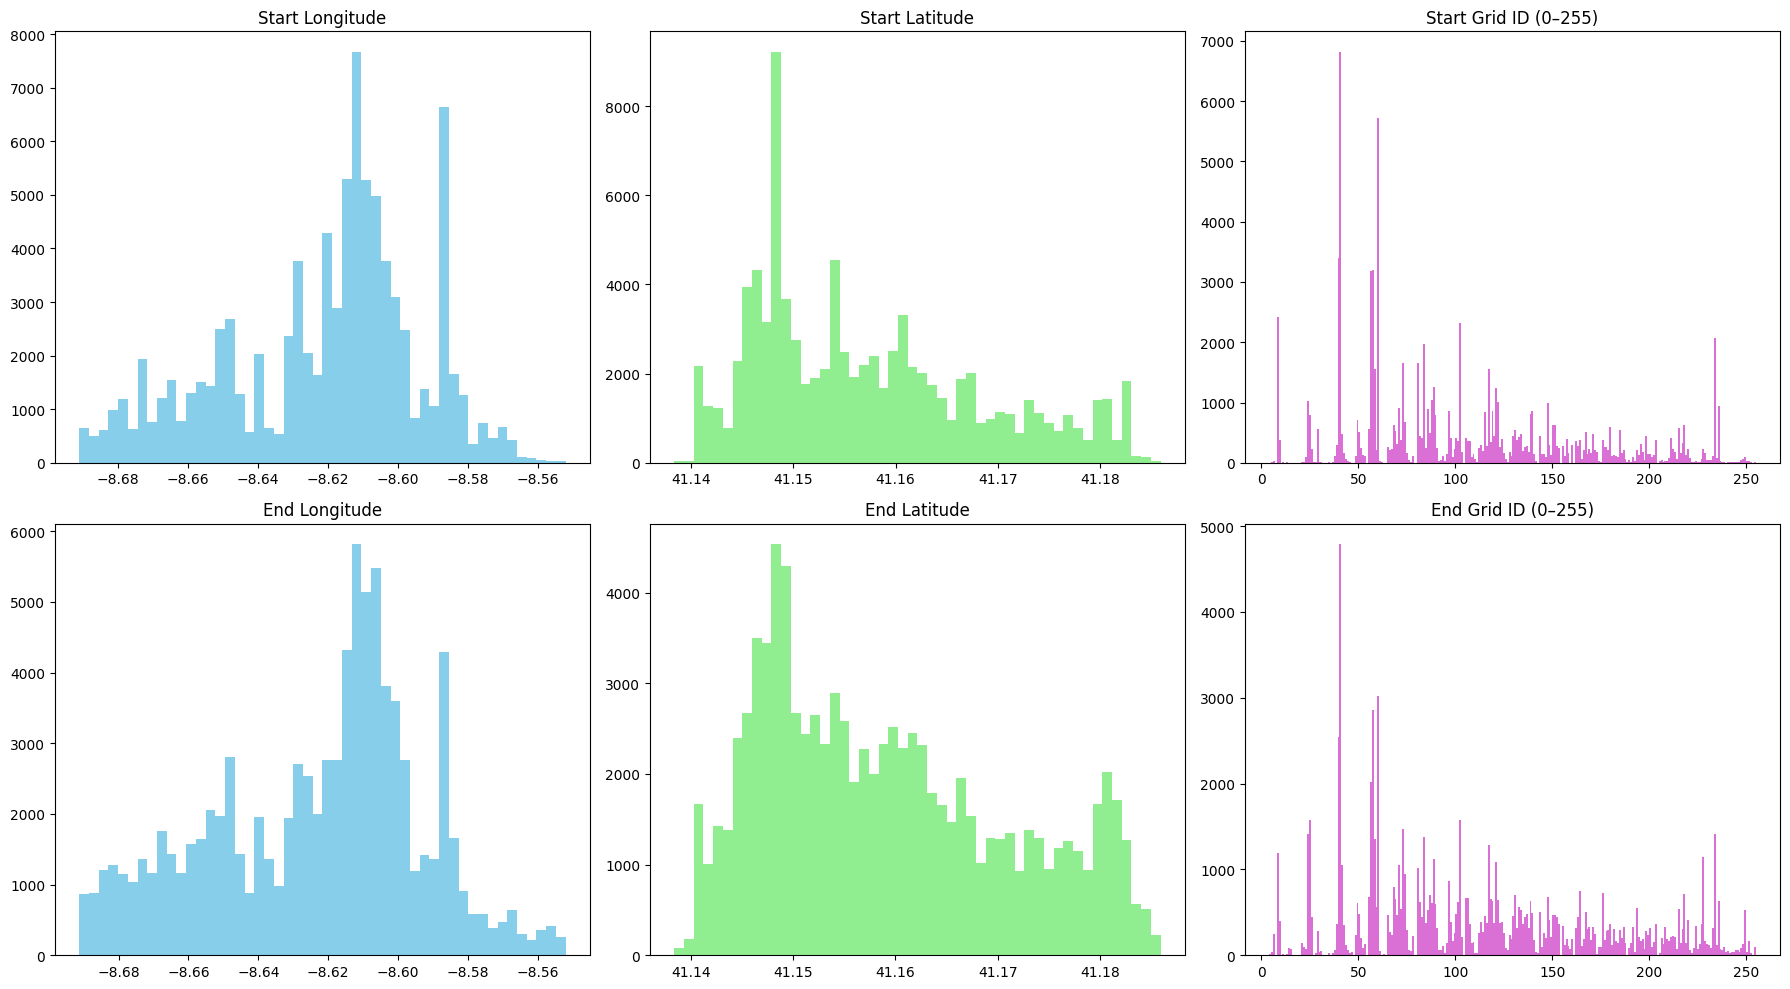

In [26]:
# plot the histogram about the starting and ending coordinates, do not execute!

import matplotlib.pyplot as plt
# Extract start and end points from POLYLINE
start_lons = []
start_lats = []
end_lons = []
end_lats = []

for polyline in df_pp['POLYLINE']:
    if len(polyline) >= 2:
        start_lon, start_lat = polyline[0]
        end_lon, end_lat = polyline[-1]
        start_lons.append(start_lon)
        start_lats.append(start_lat)
        end_lons.append(end_lon)
        end_lats.append(end_lat)

# Create a new DataFrame for plotting
df_coords = pd.DataFrame({
    'start_lon': start_lons,
    'start_lat': start_lats,
    'end_lon': end_lons,
    'end_lat': end_lats,
    'start_id': df_pp.loc[df_pp['start_id'] != -1, 'start_id'].values,
    'end_id': df_pp.loc[df_pp['end_id'] != -1, 'end_id'].values
})


fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Plot histograms
axes[0, 0].hist(df_coords['start_lon'], bins=50, color='skyblue')
axes[0, 0].set_title('Start Longitude')

axes[0, 1].hist(df_coords['start_lat'], bins=50, color='lightgreen')
axes[0, 1].set_title('Start Latitude')

axes[0, 2].hist(df_coords['start_id'], bins=256, color='orchid')
axes[0, 2].set_title('Start Grid ID (0–255)')

axes[1, 0].hist(df_coords['end_lon'], bins=50, color='skyblue')
axes[1, 0].set_title('End Longitude')

axes[1, 1].hist(df_coords['end_lat'], bins=50, color='lightgreen')
axes[1, 1].set_title('End Latitude')

axes[1, 2].hist(df_coords['end_id'], bins=256, color='orchid')
axes[1, 2].set_title('End Grid ID (0–255)')

plt.tight_layout()
plt.show()


          TIMESTAMP  trip_distance  departure_time  trip_time  trip_length  \
count  9.064900e+04   90649.000000    90649.000000    90649.0      90649.0   
mean   1.389058e+09    7881.301942      166.711966     2985.0        200.0   
std    8.653314e+06    3817.143804       62.711804        0.0          0.0   
min    1.372638e+09      52.301544        0.000000     2985.0        200.0   
25%    1.382024e+09    5317.009233      122.000000     2985.0        200.0   
50%    1.388767e+09    7192.550177      179.000000     2985.0        200.0   
75%    1.396370e+09    9737.806536      215.000000     2985.0        200.0   
max    1.404172e+09   56173.064894      287.000000     2985.0        200.0   

            avg_dis     avg_speed      start_id        end_id  
count  90649.000000  90649.000000  90649.000000  90649.000000  
mean      39.406510      2.640302    101.317643    110.516332  
std       19.085719      1.278775     59.371899     63.786419  
min        0.261508      0.017521      4.

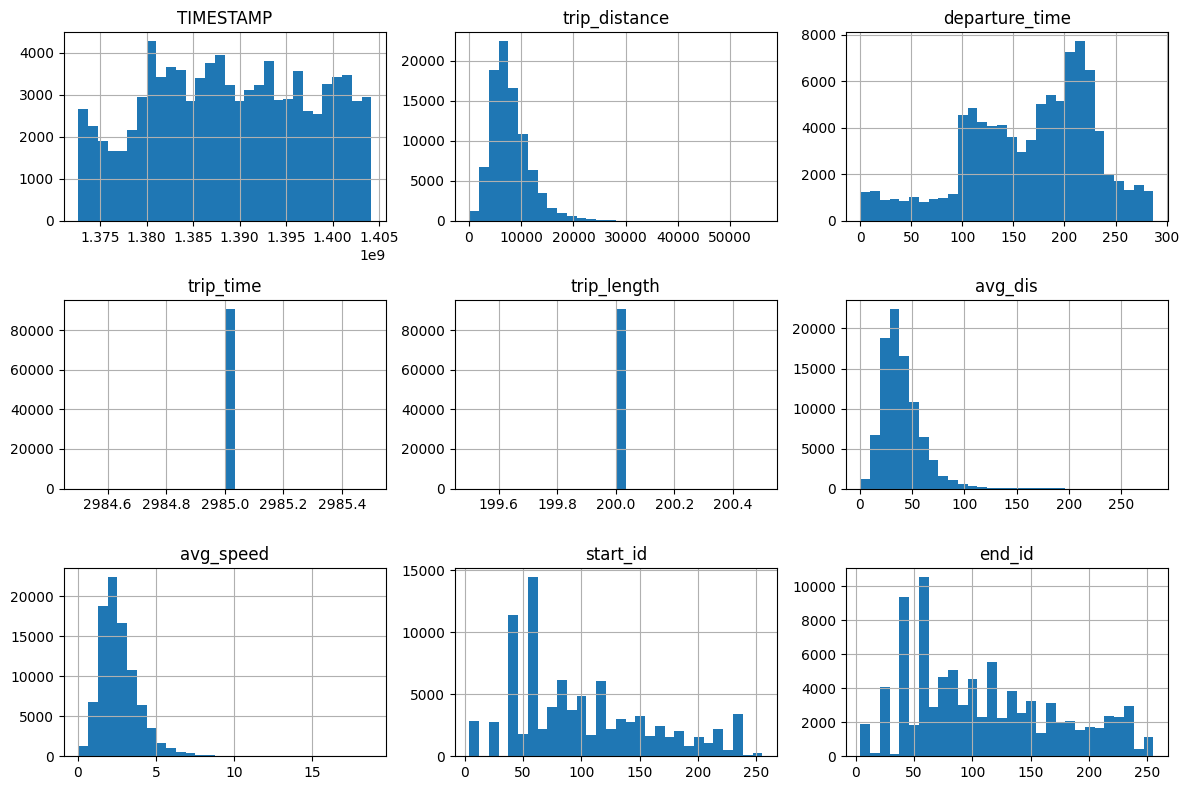

In [27]:
# describe and plot the df, , do not execute!
import matplotlib.pyplot as plt

print(df_pp.describe())

df_pp.hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()

In [8]:
# linear interpolate to length = 200
df_pp['POLYLINE'] = df_pp['POLYLINE'].progress_apply(linear_interpo)

100%|██████████| 90649/90649 [00:05<00:00, 17258.91it/s]


Processing trajectories...


Converting polylines to LineStrings: 100%|██████████| 90649/90649 [00:00<00:00, 288996.41it/s]


Plotting map...


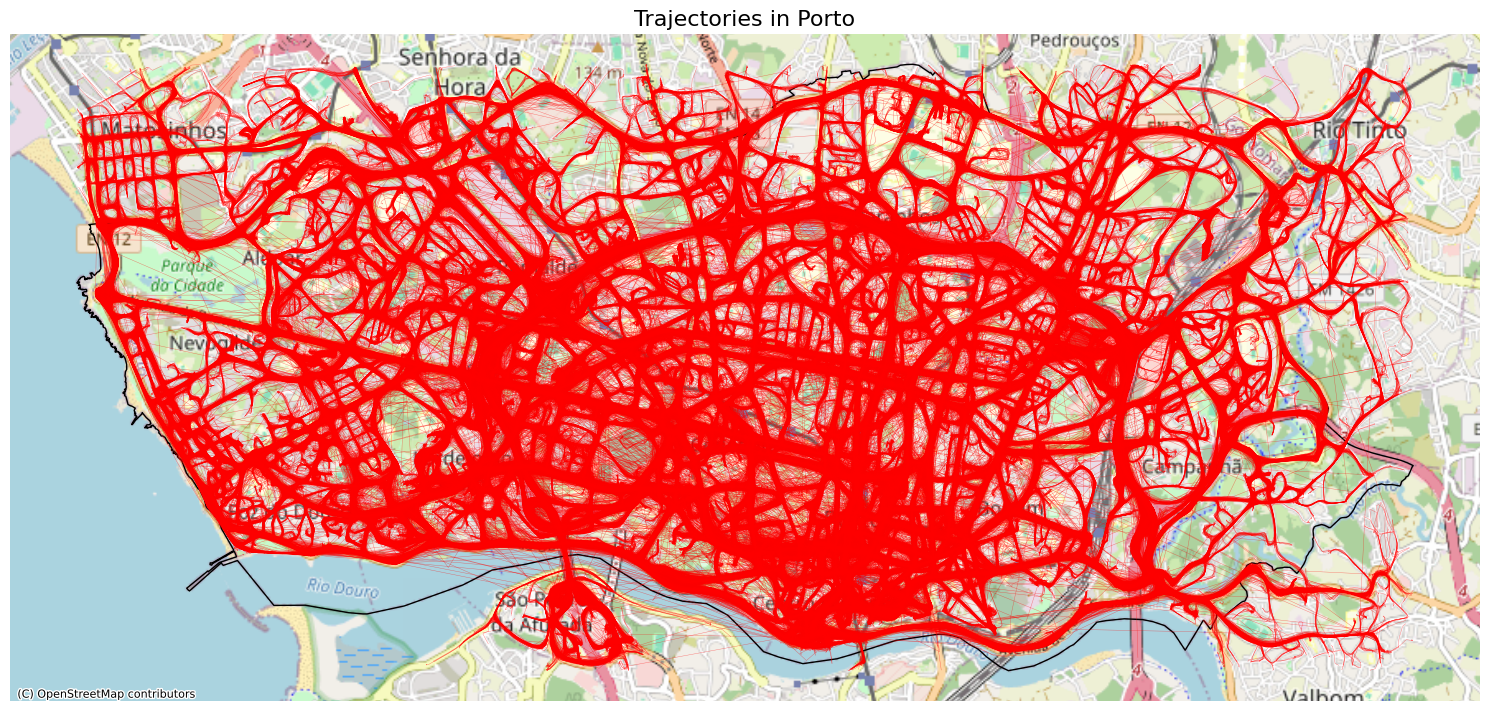

In [29]:
plot_trajectories_on_porto_map(df_pp)

In [9]:
columns = ['departure_time', 'trip_distance', 'trip_time', 'trip_length', 'avg_dis', 'avg_speed']
stats = df_pp[columns].agg(['mean', 'std'])

print(stats)

      departure_time  trip_distance    trip_time  trip_length    avg_dis  \
mean      166.711966    8029.154791  1745.890854   117.392724  74.209811   
std        62.711804    3974.428351  1072.389402    71.492627  33.856621   

      avg_speed  
mean   4.997468  
std    2.283029  


In [9]:
# Normalisation
# 'trip_distance', 'trip_time', 'trip_length', 'avg_dis', 'avg_speed'
# Departure Time, Start Grid ID, and End Grid ID do not need to be normalized.


cols_to_normalize = ['trip_distance', 'trip_time', 'trip_length', 'avg_dis', 'avg_speed']

# Apply normalization: (x - mean) / std
df_pp[cols_to_normalize] = df_pp[cols_to_normalize].apply(lambda x: (x - x.mean()) / x.std())

In [10]:
# normalise 

def normalize_polylines_zscore(df, lat_mean, lat_std, lon_mean, lon_std):
    """
    Z-score normalizes each [lon, lat] point in the POLYLINE column.

    Parameters:
        df (pd.DataFrame): Contains 'POLYLINE' as list of [lon, lat]
        lat_mean, lat_std (float): Mean and std of latitude
        lon_mean, lon_std (float): Mean and std of longitude

    Returns:
        pd.DataFrame: New DataFrame with an added 'POLYLINE_normalized' column
    """
    def normalize_poly(polyline):
        norm_poly = [ 
            [(lon - lon_mean) / lon_std, (lat - lat_mean) / lat_std]
            for lon, lat in polyline
        ]
        return norm_poly

    df = df.copy()
    df['POLYLINE_normalized'] = df['POLYLINE'].apply(normalize_poly)
    return df

lat_mean, lon_mean = 41.15821200010704, -8.622851773110616 
lat_std, lon_std=  0.010499445425612607, 0.025654276995489916

df_pp = normalize_polylines_zscore(df_pp, lat_mean, lat_std, lon_mean, lon_std)

In [11]:
###########################################################
# save to npy files
# traj: [batch_size, 2, traj_length]   2: latitude and longitude
# head: [batch_size, 8]   8: departure_time, trip_distance,  trip_time, trip_length, avg_dis, avg_speed, start_id, end_id
###########################################################

traj = df_pp['POLYLINE_normalized'].to_numpy()
traj = np.stack(traj)

np.save('porto_traj.npy', traj)


head_features = ['departure_time', 'trip_distance', 'trip_time', 'trip_length',
                 'avg_dis', 'avg_speed', 'start_id', 'end_id']

heads =  df_pp[head_features].to_numpy()
heads = np.stack(heads)

np.save('porto_heads.npy', heads)

In [12]:
import numpy as np
heads = np.load('porto_heads.npy', allow_pickle=True)
traj = np.load('porto_traj.npy', allow_pickle=True)



In [13]:
print(heads.shape)
print(traj.shape)

(90649, 8)
(90649, 200, 2)
